# Value-at-risk calculations

The basic idea behind the value-at-risk calculation is that we're going to look at the historical returns of a portfolio of securities and run many simulations to determine the range of returns we can expect from these.  We can then predict, over a given time horizon, what our expected loss is at a given probability, e.g., we might say that there is less than a 10% chance that the portfolio will lose more than $1,000,000.

Note that this is a didactic example and consequently makes some simplifying assumptions about the composition of the portfolio (i.e., only long positions in common stocks, so no options, dividends, or short selling) and the behavior of the market (i.e., day-to-day return percentages are normally-distributed and independent).  Do not use this code to guide actual investment decisions!

## Basic setup

Here we import the `pyspark` module and set up a `SparkSession`.

In [2]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.master("spark://sparky:7077").getOrCreate()

## Loading the data

We'll start by loading the data (from the WikiEOD dataset of freely-available stock closing prices).

In [3]:
df = spark.read.load("/data/wikieod.parquet")

## Calculating historical returns

We'll use Spark's windowing functions over data frames to determine the percentage change in each security from the previous close to each day's close.  Basically, we'll add a column to our data frame that represents the percentage change from the previous day's close (that is, `lag("close", 1)` when partitioned by ticker symbol and ordered by date) and the current day's close (that is, `col("close")`).

In [4]:
from pyspark.sql import Window
from pyspark.sql.functions import lag, col, avg, variance

ddf = df.select("ticker", "date", "close").withColumn("change", (col("close") / lag("close", 1).over(Window.partitionBy("ticker").orderBy(df["date"])) - 1.0) * 100)
ddf.show(10)

+------+----------+-----+------------------+
|ticker|      date|close|            change|
+------+----------+-----+------------------+
|  ACFN|1992-02-11|10.12|              null|
|  ACFN|1992-02-12|10.75| 6.225296442687744|
|  ACFN|1992-02-13| 10.0|-6.976744186046513|
|  ACFN|1992-02-14|10.12| 1.200000000000001|
|  ACFN|1992-02-18|10.25|1.2845849802371578|
|  ACFN|1992-02-19|10.38|1.2682926829268304|
|  ACFN|1992-02-20| 12.0|15.606936416184958|
|  ACFN|1992-02-21|13.12| 9.333333333333327|
|  ACFN|1992-02-24| 12.0|-8.536585365853655|
|  ACFN|1992-02-25|12.38| 3.166666666666673|
+------+----------+-----+------------------+
only showing top 10 rows



## Characterizing expected return distributions

With the range of changes now available, we can calculate our expected returns for each security.  Since this is a simple example, we'll assume that returns are normal (in the real world, you'd want to use a distribution with heavier tails or a more sophisticated technique altogether).  We can calculate the parameters for each security's distribution as follows:

In [5]:
from pyspark.sql.functions import sqrt
mv = ddf.groupBy("ticker").agg(avg("change").alias("mean"), sqrt(variance("change")).alias("stddev"))
mv.show(10)

+------+--------------------+------------------+
|ticker|                mean|            stddev|
+------+--------------------+------------------+
|  ACFN| 0.06242424778074286| 5.014939329411184|
|  ALXN| 0.15393095850020602| 4.532013447331393|
|  AWAY| 0.02539756867869776|  2.69393746555018|
|   CCK| 0.04952646560952892| 2.931715455254924|
|   CRS|0.031102171093862575| 2.499932187771903|
|  CYNI|-0.03118042941995...|4.1279080205519225|
|   GIS|0.019429696808146178| 1.721249863186511|
|  HBNC|0.027071069371644215|2.0340790030584697|
|  HWAY| 0.08017011008855986| 3.668783283957359|
|     K|0.026071743393784257|1.8036206811619875|
+------+--------------------+------------------+
only showing top 10 rows



Since there are only about 3,000 ticker symbols in our data set, we can easily collect these in driver memory for use in our simulation:

In [6]:
dist_map = mv.rdd.map(lambda r: (r[0], (r[1], r[2]))).collectAsMap()
dist_map["RHT"]

(0.08187986469765945, 3.8769620645490304)

## Getting current security prices

We'll now identify the latest price for each security in our dataset:

In [7]:
from pyspark.sql.functions import first
priceDF = ddf.orderBy("date", ascending=False).groupBy("ticker").agg(first("close").alias("price"), first("date").alias("date"))
priceDF.show(10)

prices = priceDF.rdd.map(lambda r: (r[0], r[1])).collectAsMap()

+------+-----+----------+
|ticker|price|      date|
+------+-----+----------+
|  ACFN| 0.26|2015-07-23|
|  ALXN|129.0|2016-11-04|
|  AWAY|35.77|2015-12-14|
|   CCK|53.04|2016-11-04|
|   CRS|31.75|2016-11-04|
|  CYNI|  5.7|2015-07-31|
|   GIS|60.65|2016-11-04|
|  HBNC|27.59|2016-11-04|
|  HWAY|19.45|2016-11-04|
|     K|73.67|2016-11-04|
+------+-----+----------+
only showing top 10 rows



## Setting up a simulation

We'll now define our simulation.  This involves three steps: 

1.  We'll start by generating a random portfolio of securities (a map from ticker symbols to values); then, 
2.  we'll decide how many simulations to run and generate a random seed for each; and, finally
3.  we'll actually run the simulation for a given number of training days, updating the value of our portfolio with random returns sampled from the distribution of historical returns.

Generating the random portfolio is pretty straightforward:

In [8]:
from random import randint, seed

def random_portfolio(symbols):
    result = {}
    for s in symbols:
        result[s] = prices[s] * (randint(1, 1000) * 11)
    return result

def portfolio_value(pf):
    return sum([v for v in pf.values()])

seed(0xdea110c8)

portfolio = random_portfolio(ddf.select("ticker").distinct().sample(True, 0.01, 0xdea110c8).rdd.map(lambda r: r[0]).collect())

As is generating a collection of random seeds:

In [9]:
def seeds(count):
    return [randint(0, 1 << 32 - 1) for i in range(count)]

We'll define a single step of our simulation (and, subsequently, a whole run of the simulation) next:

In [10]:
def simstep(pf, params, prng):
    def daily_return(sym):
        mean, stddev = params[sym]
        change = (prng.normalvariate(mean, stddev) + 100) / 100.0
        return change
    return dict([(s, daily_return(s) * v) for s, v in pf.items()])

def simulate(seed, pf, params, days):
    from random import Random
    prng = Random()
    prng.seed(seed)
    pf = pf.copy()
    
    for day in range(days):
        pf = simstep(pf, params, prng)
    return pf

Now we have everything we need to actually run the simulation.  For each seed, we'll spawn a Spark job to simulate 5 days of activity on our portfolio and then return the total dollar value of our gain or loss at the end of the period.

In [11]:
sc = spark.sparkContext
seed_rdd = sc.parallelize(seeds(10000))
bparams = sc.broadcast(dist_map)
bpf = sc.broadcast(portfolio)
initial_value = portfolio_value(portfolio)

results = seed_rdd.map(lambda s: portfolio_value(simulate(s, bpf.value, bparams.value, 5)) - initial_value)

In [12]:
simulated_results = list(zip(results.collect(), seed_rdd.collect()))
simulated_values = [v for (v, _) in simulated_results]
simulated_values.sort()

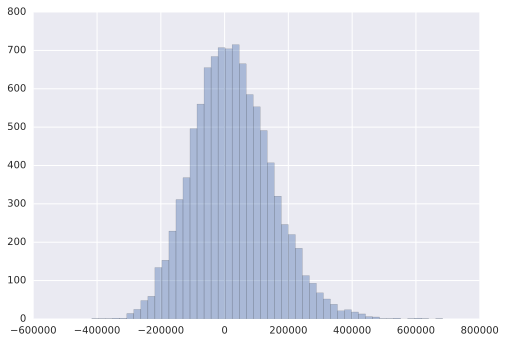

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import numpy as np
sns.set(color_codes=True)

_ = sns.distplot(simulated_values, kde=False)


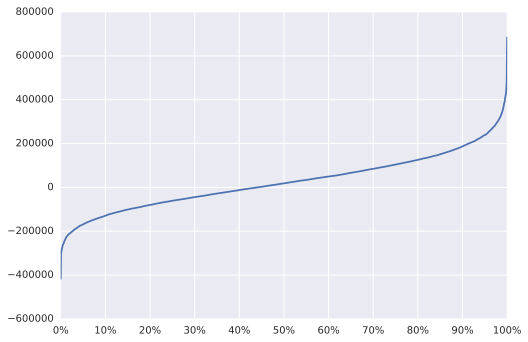

In [34]:
xvals = [float(i) / len(simulated_values) for i in range(len(simulated_values))]
ax = sns.tsplot(np.array(simulated_values), np.array(xvals), markevery=0.5)
ax.get_xaxis().set_ticks([i * 0.1 for i in range(11)])
_ = ax.get_xaxis().set_ticklabels(["%d%%" % (i * 10) for i in range(11)])

Since the market historically trends up, we have a better than even chance of not losing money in our simulation.  We can see the 5% value at risk over our time horizon.

In [16]:
simulated_values[int(len(simulated_values) * 0.05)]

-170488.99104319979

## Visualizing random walks

Finally, let's look at some example simulation runs to see how the portfolio value changes over time.  We'll take the runs with the best and worst returns and also the runs at each decile.  To visualize our simulation, we'll need a slightly different `simulate` function:

In [37]:
def simulate_with_history(seed, pf, params, days):
    from random import Random
    prng = Random()
    prng.seed(seed)
    pf = pf.copy()
    values = [portfolio_value(pf)]
    
    for day in range(days):
        pf = simstep(pf, params, prng)
        values.append(portfolio_value(pf))
    return values

We'll now repeat the simulation on eleven of our seeds from the earlier run, collecting history for each:

In [38]:
simulated_results.sort()
eleven_results = [simulated_results[int((len(simulated_results) - 1) * i / 10)] for i in range(11)]
eleven_seeds = sc.parallelize([seed for (_, seed) in eleven_results])
walks = eleven_seeds.map(lambda s: simulate_with_history(s, bpf.value, bparams.value, 5))

walk_results = walks.collect()

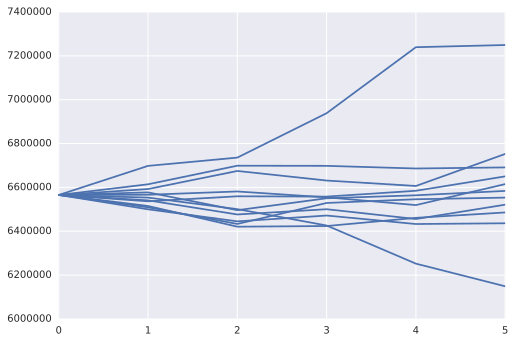

In [43]:
for c in walk_results:
    _ = sns.tsplot(c)

# Getting more realistic results

Of course, most real-world stock returns aren't normally distributed.  To make a more interesting simulation, we can try to find a distribution that better models the returns we've observed.

We'll start by looking at the actual distributions of returns.  The Seaborn `distplot` function will plot a histogram of returns and fit a [kernel density estimate](https://en.wikipedia.org/wiki/Kernel_density_estimation) to the observations.  To see this in action, we'll try it out first with a single security:

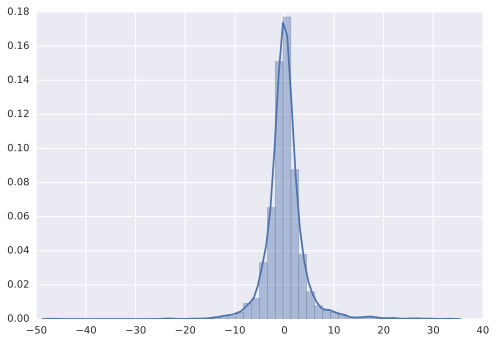

In [44]:
rdist = ddf.filter(ddf["ticker"] == "RHT").select("change").rdd.map(lambda r: r["change"]).filter(lambda c: c is not None).collect()
sns.distplot(rdist)

As we can see, the distribution for this particular security doesn't look all that normal.  While there are various [statistical techniques to quantify](https://en.wikipedia.org/wiki/Goodness_of_fit) just how bad of a fit the normal distribution is for our observations (see in particular [this one](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)), `distplot` will let us visually compare an empirically-observed distribution to an ideal distribution in order to see how well the latter fits the former.  We can do this to see just how far this distribution is from normal.

We'll first import a library of models and then plot the expected return distribution if returns were normal:

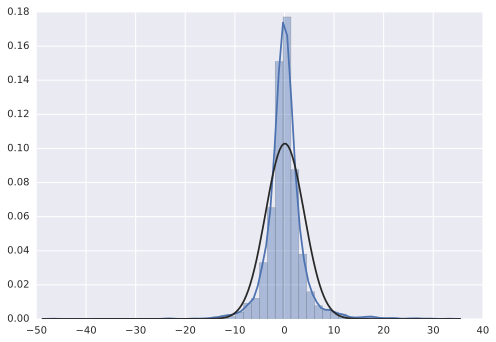

In [45]:
from scipy import stats
sns.distplot(rdist, fit=stats.norm)

As we can see, the normal distribution (black line) is not a great fit for the kernel density estimate of our observations (blue line).  While we'd want a more rigorous way to choose models in a production application, looking at the returns from multiple securities is a good way to continue our exploration of these data.  We'll do that now.

First, we'll choose a small number of securities at random:

In [60]:
symbols = ddf.select("ticker").distinct().sample(True, 0.001).rdd.map(lambda l: l["ticker"]).collect()

Now we'll use Spark to generate a data frame with all of the returns for each symbol in `symbols`:

In [61]:
dfs = ddf.filter(ddf["ticker"].isin(symbols)).select("ticker", "change").dropna()
sampled_returns = dfs.toPandas()

Let's unpack what's happening here:

1.  We start with `ddf`, our `DataFrame` of stock returns.
2.  We're going to filter out any row that isn't for a symbol we care about.  In SQL, this would look like `SELECT ticker, change WHERE ticker IN ...`; in the Spark data frame DSL we use `isin`, like this:  `ddf["ticker"].isin(symbols)`.
3.  The return for the first day we have data for each ticker symbol will be null (by definition), and we don't want to have to deal with those in our plot functions.  The `dropna()` function is a convenient way to do this.
4.  Finally, we're going to collect the Spark data frame in memory and convert it to a Pandas data frame, which will make it easier to plot.

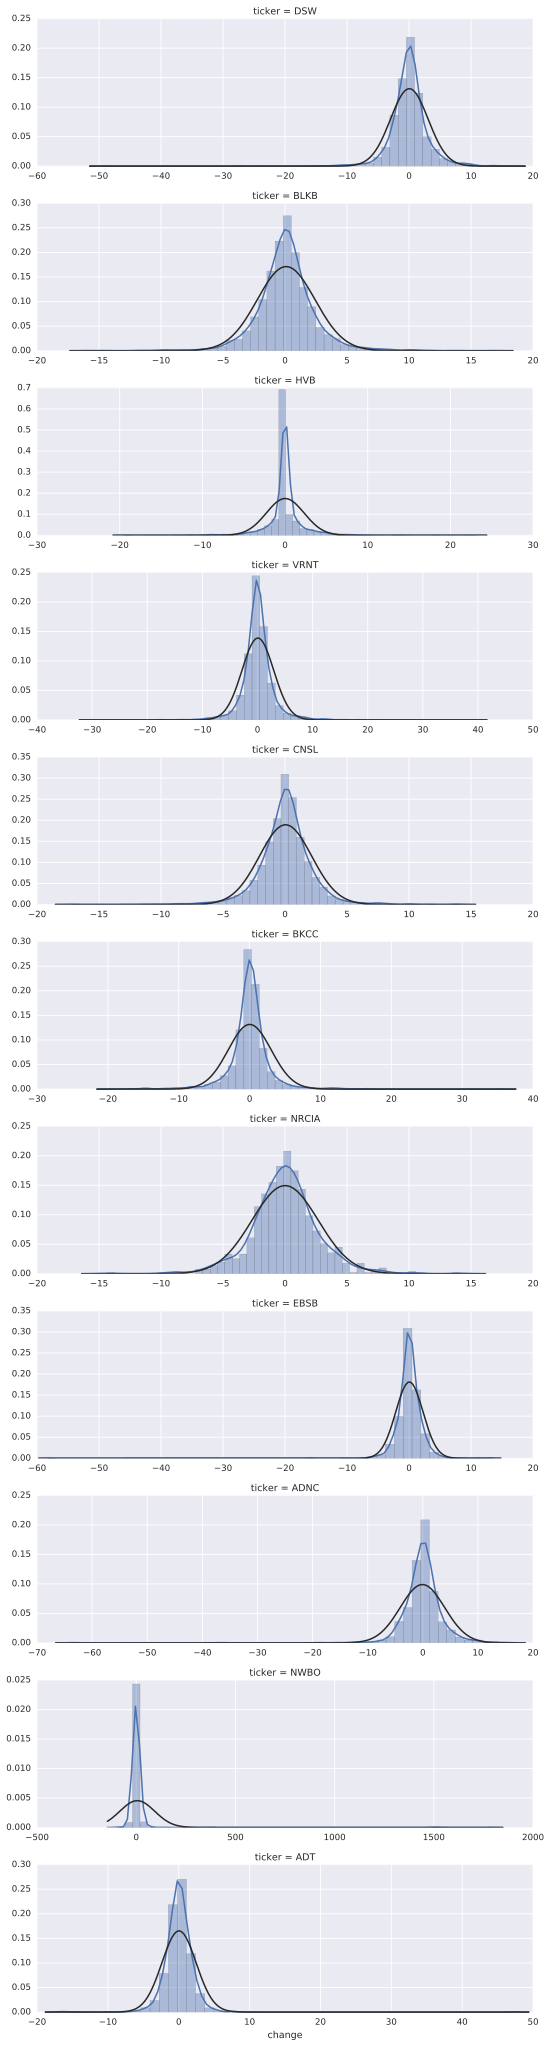

In [62]:
g = sns.FacetGrid(sampled_returns, row="ticker", sharex=False, sharey=False, aspect=3)
_ = g.map(sns.distplot, "change", fit=stats.norm)

You can re-run this experiment several times to see the results with a different set of sampled ticker symbols.

In [69]:
def plot_returns(df, frac=0.001, dist=stats.norm):
    "Plot the distribution returns for a selection of securities against another distribution"
    symbols = df.select("ticker").distinct().sample(True, frac).rdd.map(lambda l: l["ticker"]).collect()
    dfs = df.filter(df["ticker"].isin(symbols)).select("ticker", "change").dropna()
    sampled_returns = dfs.toPandas()
    g = sns.FacetGrid(sampled_returns, row="ticker", sharex=False, sharey=False, aspect=3)
    g.map(sns.distplot, "change", fit=dist)

The `plot_returns` function above will let us experiment some more as well:  we can specify the fraction of ticker symbols to consider (set it larger if you're feeling particularly patient), and we can also specify a distribution to plot against our empirical observations.  Try it out!

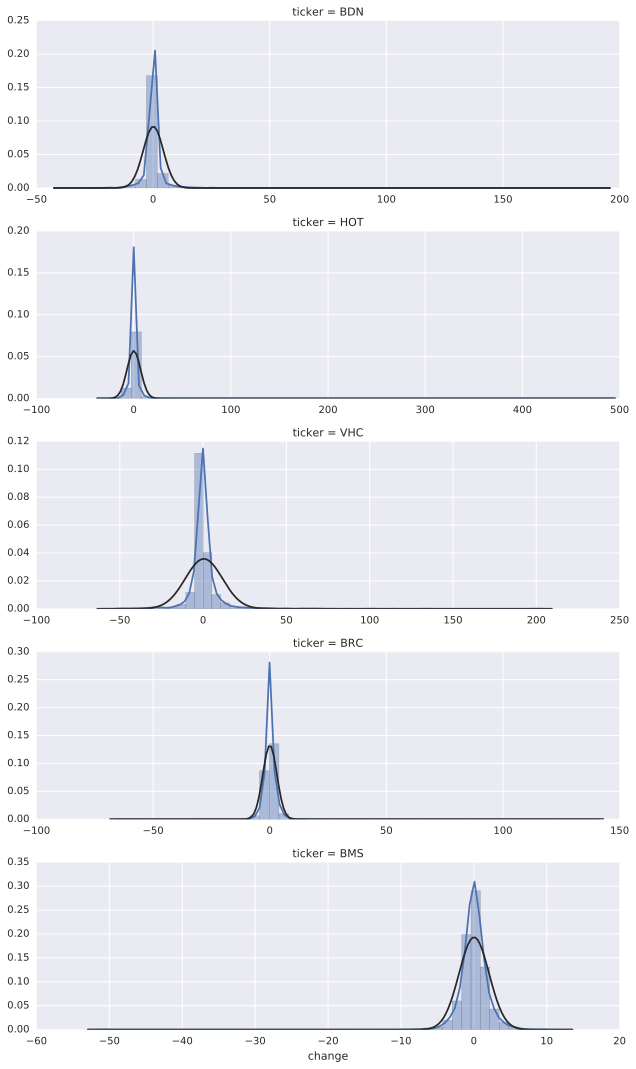

In [70]:
plot_returns(ddf, 0.001, stats.norm)

We have the intuition that the normal distribution isn't the best option, and this provides us an easy way to look for a better one.  Start by seeing [what distributions are available in the SciPy `stats` module](https://docs.scipy.org/doc/scipy/reference/stats.html):

In [64]:
dir(stats)

Now you can try some different distributions and see if one looks like a good option.  What distributions seem to be good fits?  With some more exploratory work, you're able to turn this example code into a more realistic simulation.

# Exercises

1.  Find a distribution that is a better fit for the stock returns data.
2.  Use this distribution to fit models to each ticker symbol and develop a new `simulate` method to sample from these distributions rather than from normal distributions.  Compare the results of this simulation to the results of the simulation
3.  &starf; Implement a goodness-of-fit test of your choice.
4.  Using the test you developed above, evaluate the distribution fits for every symbol.  Are there any particularly bad fits?
5.  &starf; Identify some additional distributions to use for modeling security returns that don't work well with the distribution you identified above.  Build a more sophisticated simulation that chooses one of several possible distributions for each security to find the best fit.
6.  &starf; Past performance is no guarantee of future results, but it's one of the best indicators we have.  Nevertheless, we should be careful.  What are some potential pitfalls and limitations of this general approach?